In [51]:
import os

In [71]:
%pwd

'c:\\Users\\pouru\\OneDrive\\Desktop\\360_digit_mg_solution\\360_digit_mg_project\\Fair-and-Efficient-Bonus-Allocation-System'

In [3]:
os.chdir("../")

In [44]:
%pwd

'c:\\Users\\pouru\\OneDrive\\Desktop\\360_digit_mg_solution\\360_digit_mg_project\\Fair-and-Efficient-Bonus-Allocation-System'

In [72]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path

In [73]:
from src.Bonus_Allocation_System.constants import *
from src.Bonus_Allocation_System.utils.common import read_yaml,create_directories

In [74]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])
    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation

        create_directories([config.root_dir])

        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,
            data_path=config.data_path,
        )

        return data_transformation_config

In [75]:
import os
from src.Bonus_Allocation_System.logging import logger
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [76]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config


    def train_test_spliting(self):
        data = pd.read_csv(self.config.data_path)

        logger.info("Shape of the data")
        logger.info(data.shape)

        logger.info("Information about the data")
        logger.info(data.info())

        logger.info("Type Casting (converting customer_id datatype from int to object)")
        data["customer_id"]=data["customer_id"].astype("object")

        logger.info("Partitioning the dataset based on feature type, separating numerical and categorical attributes.")
        numerical_data = data.select_dtypes(exclude="object")
        numerical_features = data.select_dtypes(exclude="object").columns

        categorical_data = data.select_dtypes(include="object")
        categorical_features = data.select_dtypes(include="object").columns

        logger.info("Shape of the numerical data")
        logger.info(numerical_data.shape)

        logger.info("Shape of the categorical data")
        logger.info(categorical_data.shape)

        logger.info("Information about the numerical data")
        logger.info(numerical_data.info())

        logger.info("Finding the correlation between the numerical data")

        sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm',annot_kws={"size":4}) 
        plt.figure(figsize=(30,30))
        plt.show()

        logger.info("Discription of the numerical data")
        logger.info(numerical_data.describe())

        logger.info("Skewness of the numerical data ")
        logger.info(numerical_data.skew(axis=0,skipna=True))

        logger.info("Kurtosis of the numerical data ")
        logger.info(numerical_data.kurtosis(axis=0,skipna=True))

        logger.info("Handling Duplicates ")
        logger.info(numerical_data.duplicated().sum())
        logger.info("There is no duplicated data present in the dataset")


        logger.info("Finding the outlier in the dataset ")
        numerical_data.plot(kind = 'box', subplots = True,sharey=False, vert =0,sharex = False,layout = [8,2], figsize=(20,20)) 
        plt.subplots_adjust(wspace = 0.75) 
        plt.show()

        logger.info("Applying winsorizer technique in the numerical data")

        
        winsor = Winsorizer(capping_method = 'iqr', 
                          tail = 'both',
                          fold = 1.5,
                          variables = ['age', 'income_level', 'Winning_percentage', 'Days_Since_Last_Bet',
       'Active_Days', 'Total_Number_of_Bets', 'Total_Amount_Wagered',
       'Average_Bet_Amount', 'Number_of_Bonuses_Received',
       'Amount_of_Bonuses_Received', 'Revenue_from_Bonuses',
       'Increase_in_Bets_After_Bonus', 'Increase_in_wagering_after_Bonus',
       'Should_Receive_Bonus'])
        
        numerical_data_1 = pd.DataFrame(winsor.fit_transform(numerical_data), columns = numerical_data.columns).convert_dtypes()

        logger.info("Numerical data after the winsorisation is applied")

        numerical_data.plot(kind = 'box', subplots = True,sharey=False, vert =0,sharex = False,layout = [8,2], figsize=(20,20)) 
        plt.subplots_adjust(wspace = 0.75) 
        plt.show()

        logger.info("Applying univariate analysis for numerical featues ")

        plt.figure(figsize=(15,15))
        plt.suptitle('Univariate Analysis for Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)


        for i in range(0, len(numerical_features)):
            plt.subplot(8, 2, i+1)
            sns.kdeplot(x=numerical_data[numerical_features[i]], color='blue')
            plt.xlabel(numerical_features[i])
            plt.tight_layout()


        numerical_data_1 = numerical_data[['income_level', 'Winning_percentage', 'Days_Since_Last_Bet',
       'Active_Days', 'Total_Number_of_Bets', 'Total_Amount_Wagered',
       'Average_Bet_Amount', 'Number_of_Bonuses_Received',
       'Amount_of_Bonuses_Received', 'Revenue_from_Bonuses',
       'Increase_in_Bets_After_Bonus', 'Increase_in_wagering_after_Bonus']]
        numerical_features_1 = numerical_data_1.columns

        plt.figure(figsize=(15,15))
        plt.suptitle('Univariate Analysis for Transformed Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

        for i in range(0, len(numerical_features_1)):
            plt.subplot(8, 2, i+1)
            feature_data = numerical_data_1[numerical_features_1[i]]
            
            # Apply Box-Cox transformation
            transformed_data, lambda_value = stats.boxcox(feature_data + 1)  # Add 1 to handle non-positive values
            
            sns.kdeplot(x=transformed_data, color='blue')
            plt.xlabel(f'{numerical_features_1[i]} (Box-Cox, lambda={lambda_value:.2f})')
            plt.tight_layout()

        

        percentage = numerical_data["Should_Receive_Bonus"].value_counts(normalize=True)
        labels = ["Receive","Denied"]
        logger.info("pie chat to show the number of denied and receive bonuses")
        fig, ax = plt.subplots(figsize =(15, 8))
        explode = (0, 0.1)
        colors = ['#1188ff','#e63a2a']
        ax.pie(percentage, labels = labels, startangle = 90,
        autopct='%1.2f%%',explode=explode, shadow=True, colors=colors)
        plt.show()





        X = data[['Winning_percentage', 'Average_Bet_Amount',
       'Number_of_Bonuses_Received', 'Amount_of_Bonuses_Received',
       'Revenue_from_Bonuses','Should_Receive_Bonus']]
        # Split the data into training and test sets. (0.75, 0.25) split.
        train, test = train_test_split(X, random_state=0)

        train.to_csv(os.path.join(self.config.root_dir, "train.csv"),index = False)
        test.to_csv(os.path.join(self.config.root_dir, "test.csv"),index = False)

        logger.info("Splited data into training and test sets")
        logger.info("Shape of the training data")
        logger.info(train.shape)
        logger.info("Shape of the test data")
        logger.info(test.shape)


[yaml file: config\config.yaml loaded successfully]
[yaml file: params.yaml loaded successfully]
[yaml file: schema.yaml loaded successfully]


[created directory at: artifacts]
[created directory at: artifacts/data_transformation]
[Shape of the data]
[(5000, 19)]
[Information about the data]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   customer_id                       5000 non-null   int64 
 1   first_name                        5000 non-null   object
 2   last_name                         5000 non-null   object
 3   country                           5000 non-null   object
 4   age                               5000 non-null   int64 
 5   gender                            5000 non-null   object
 6   income_level                      5000 non-null   int64 
 7   Winning_percentage                5000 non-null   int64 
 8   Days_Since_Last_Bet               5000 non-null   int64 
 9   Active_Days                       5000 non-null   int64 

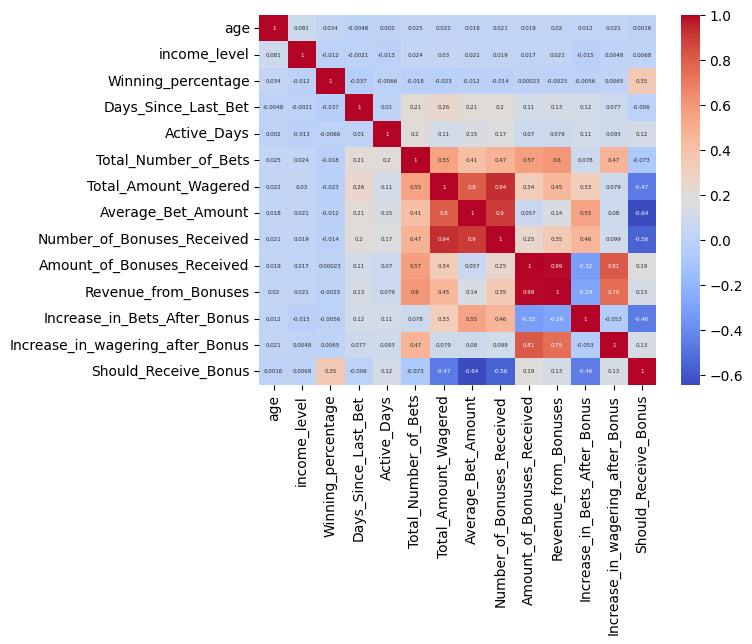

<Figure size 3000x3000 with 0 Axes>

[Discription of the numerical data]
[               age   income_level  Winning_percentage  Days_Since_Last_Bet  \
count  5000.000000    5000.000000         5000.000000          5000.000000   
mean     48.593600   85796.182400           41.601600            20.274000   
std      18.140779   37311.262225           21.781464            11.814823   
min      18.000000   20058.000000            5.000000             1.000000   
25%      33.000000   54285.750000           23.000000            10.000000   
50%      49.000000   86009.000000           41.000000            20.000000   
75%      64.000000  118290.000000           60.000000            31.000000   
max      80.000000  149879.000000           79.000000            40.000000   

       Active_Days  Total_Number_of_Bets  Total_Amount_Wagered  \
count   5000.00000           5000.000000           5000.000000   
mean     226.45920             33.198800          61843.169600   
std       81.45538             10.783809          27267.948181

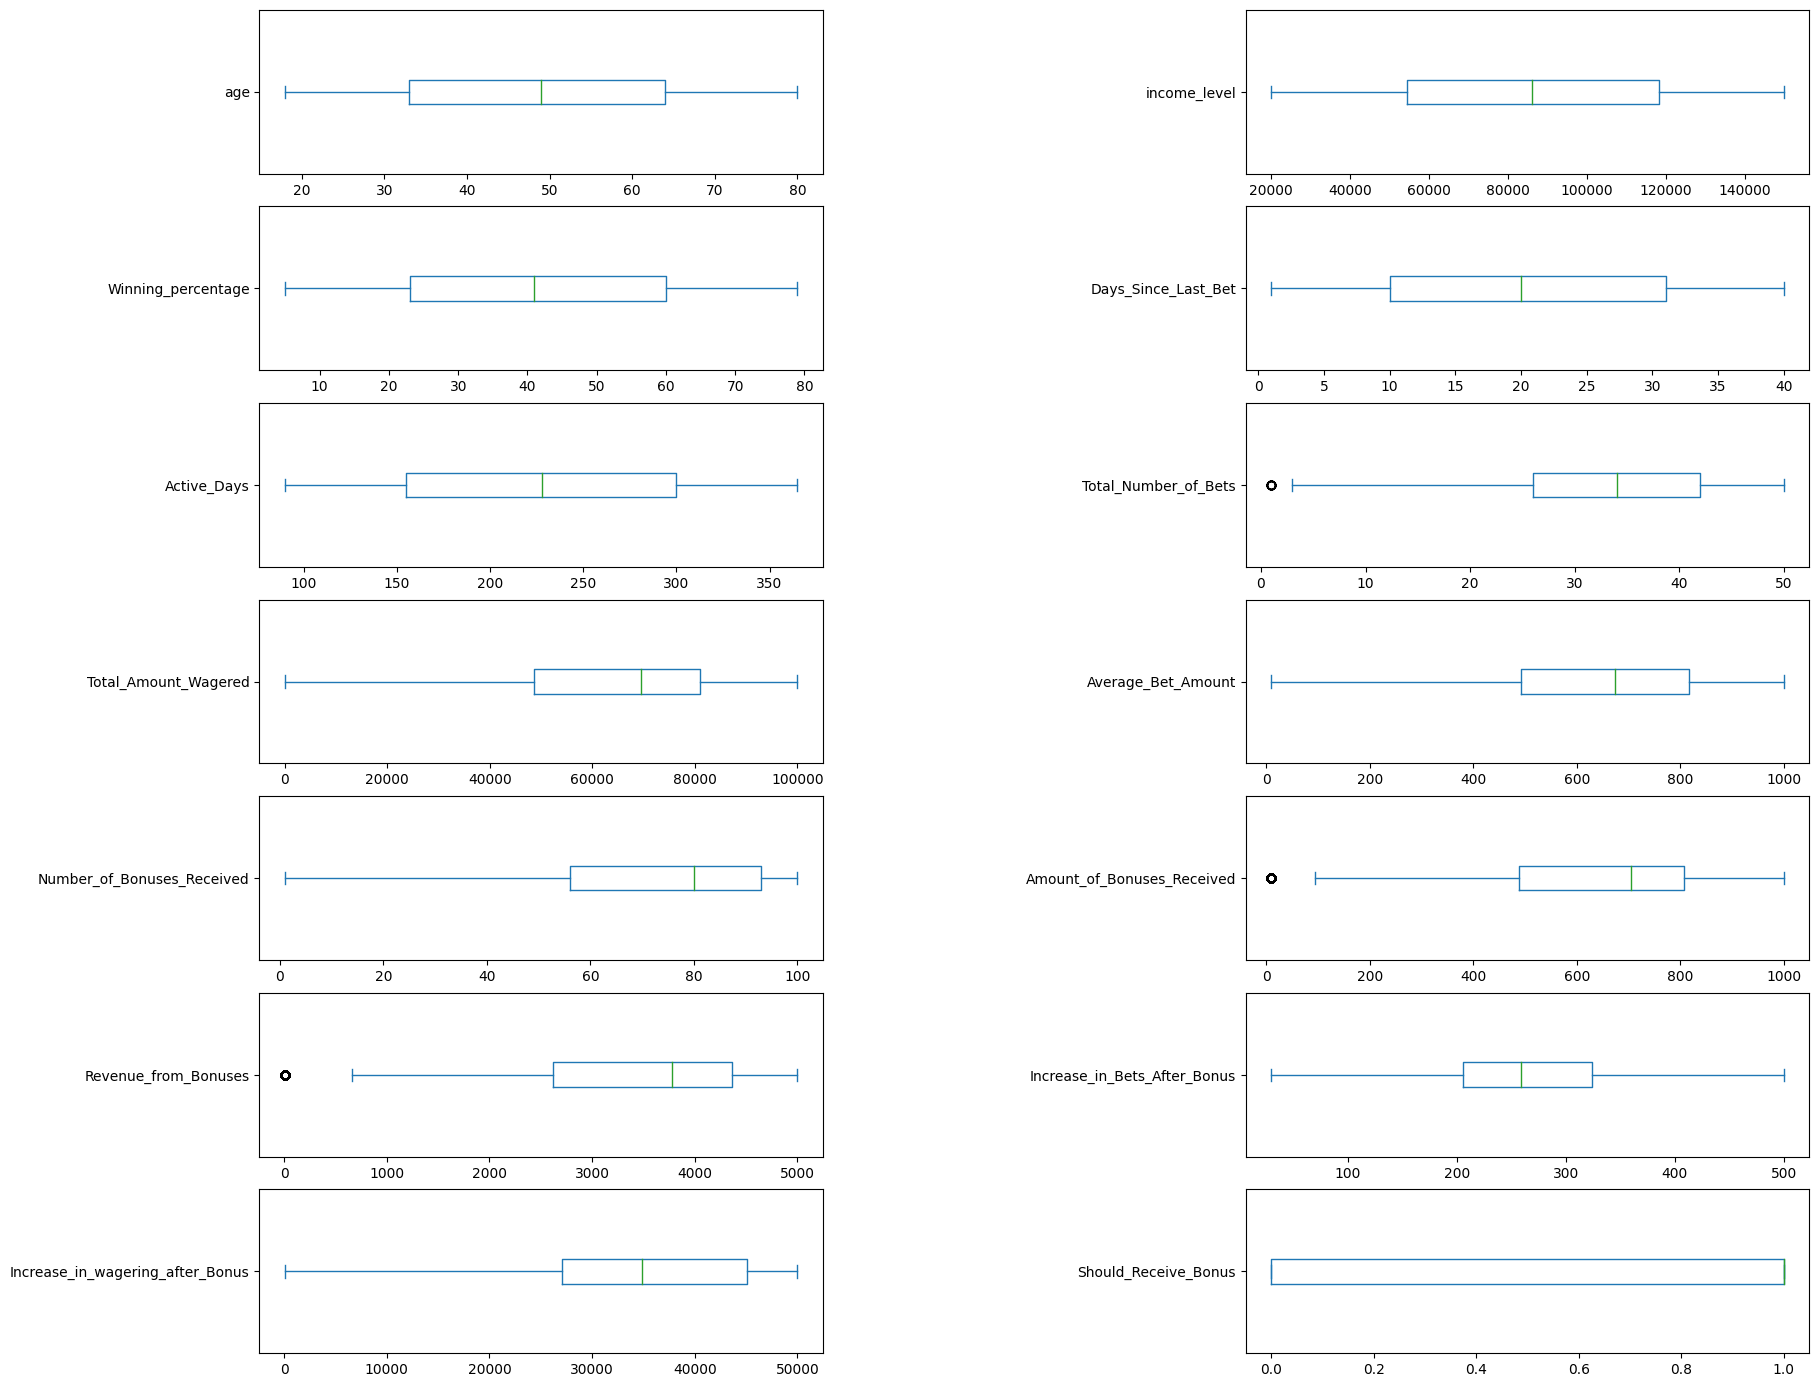

[Applying winsorizer technique in the numerical data]
[Numerical data after the winsorisation is applied]


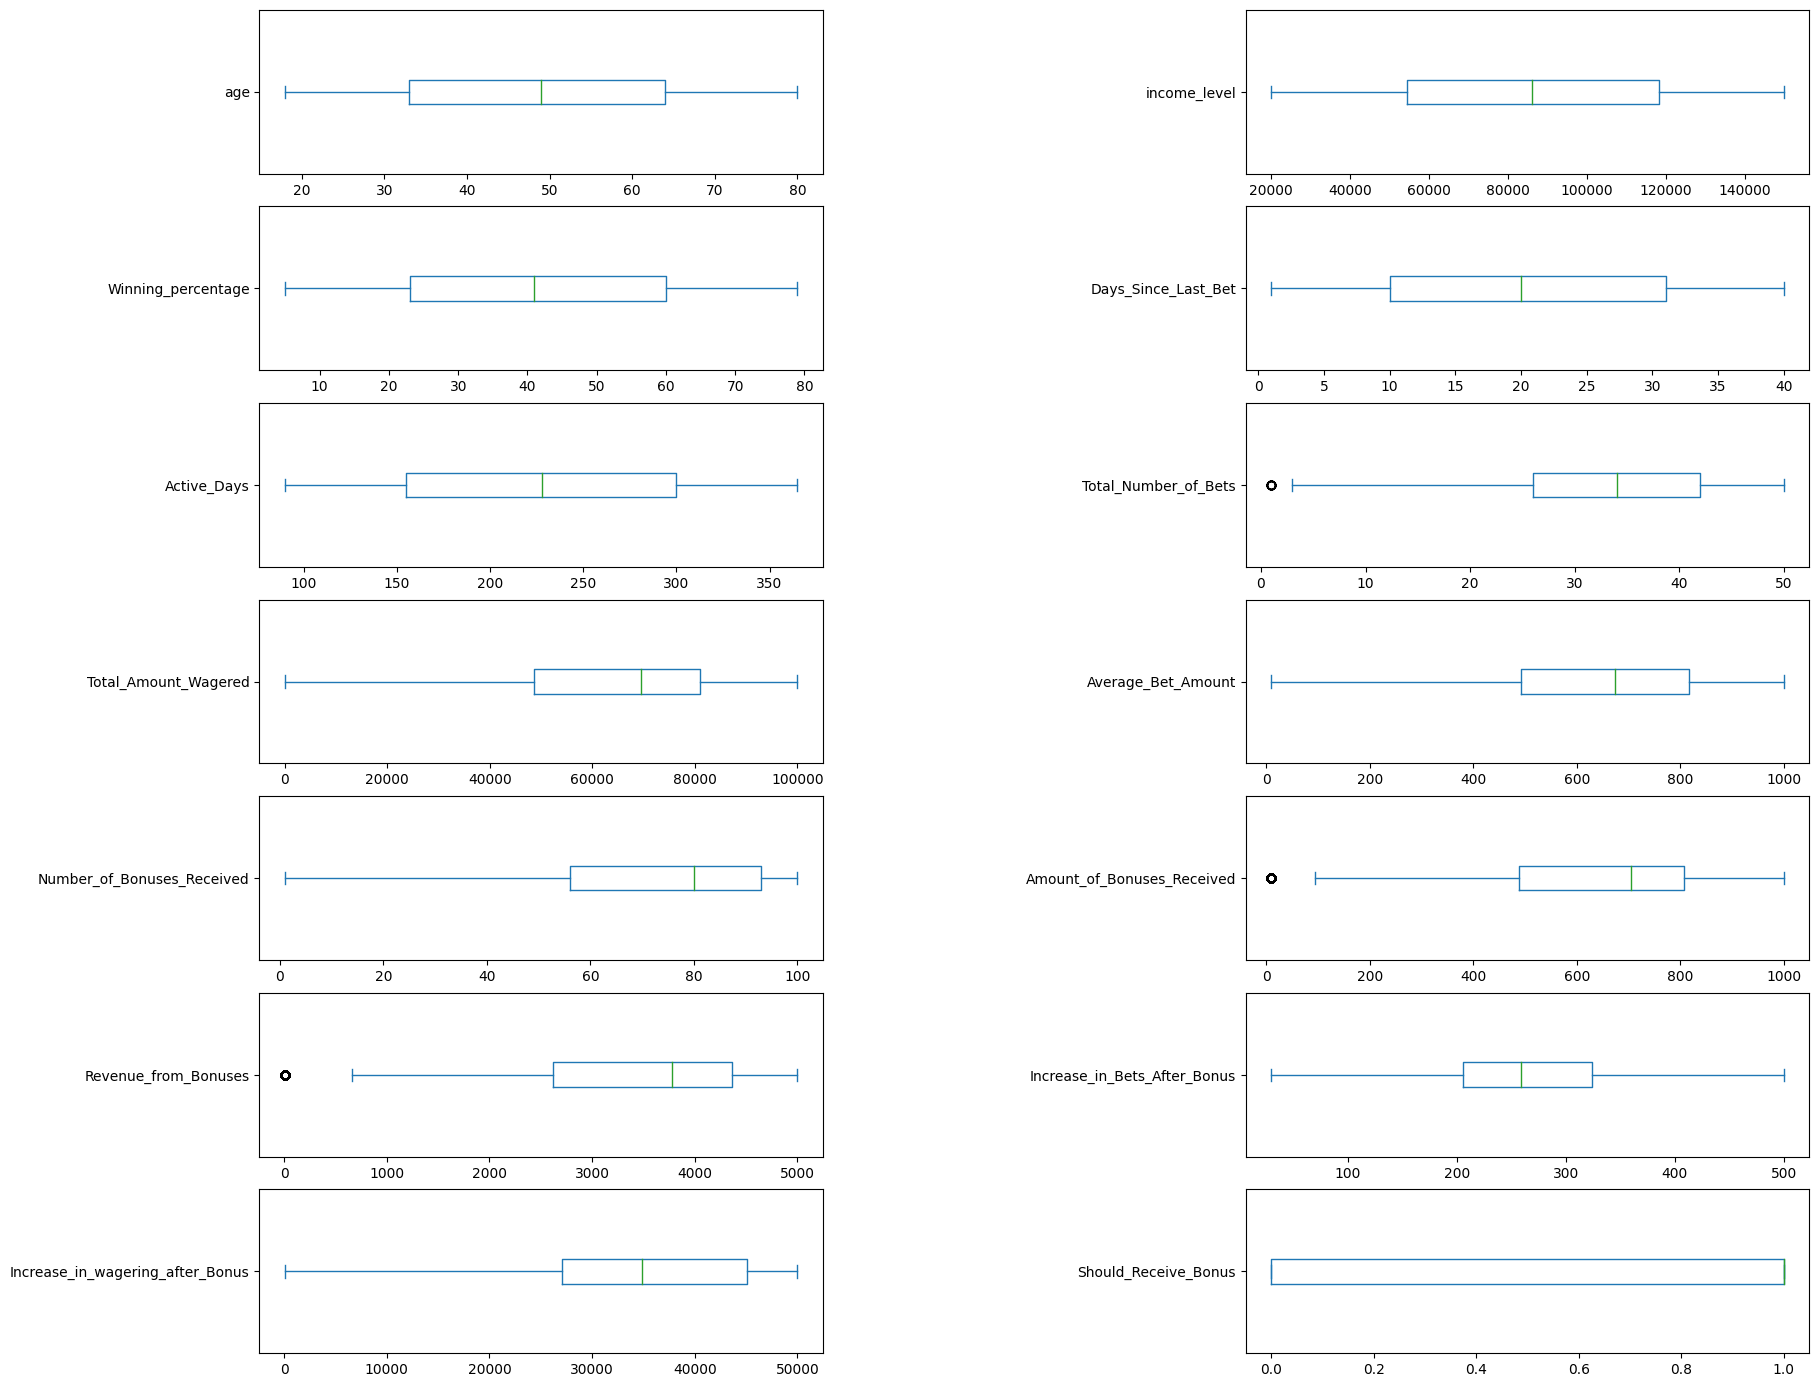

[Applying univariate analysis for numerical featues ]
[pie chat to show the number of denied and receive bonuses]


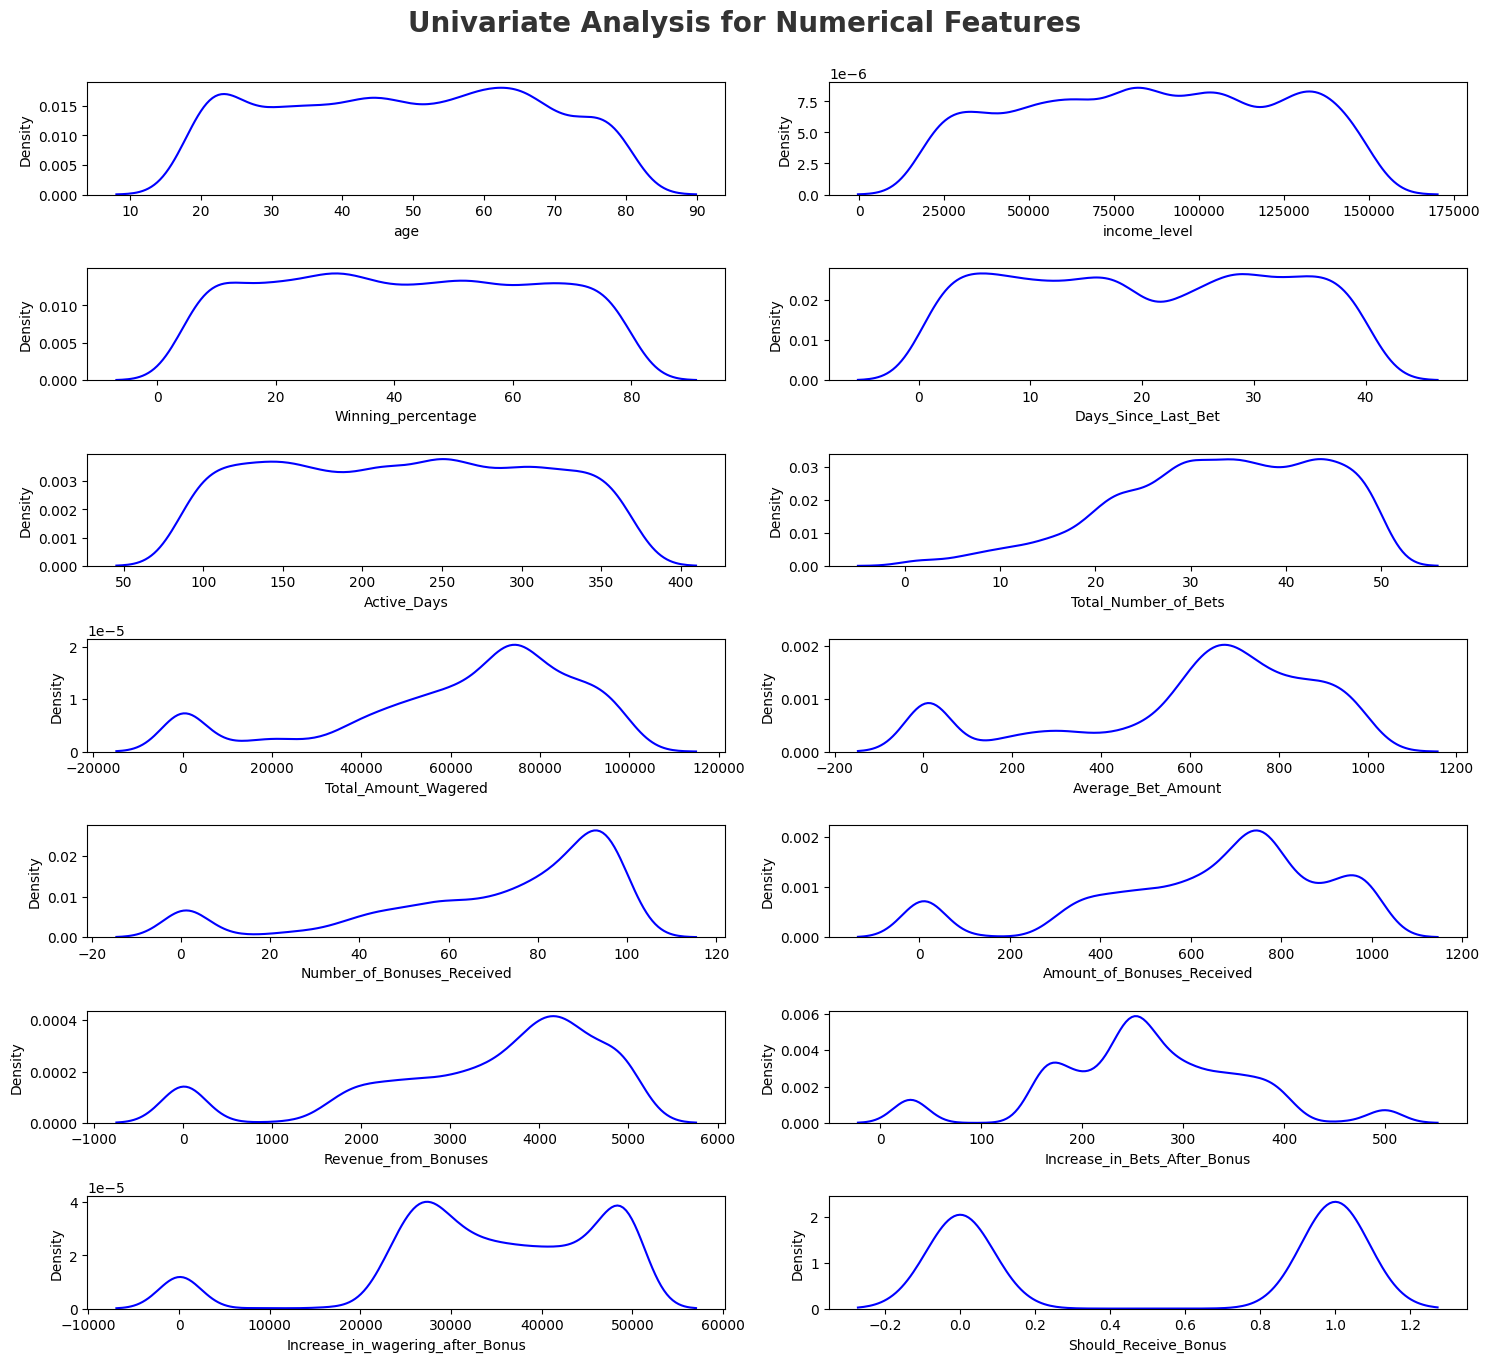

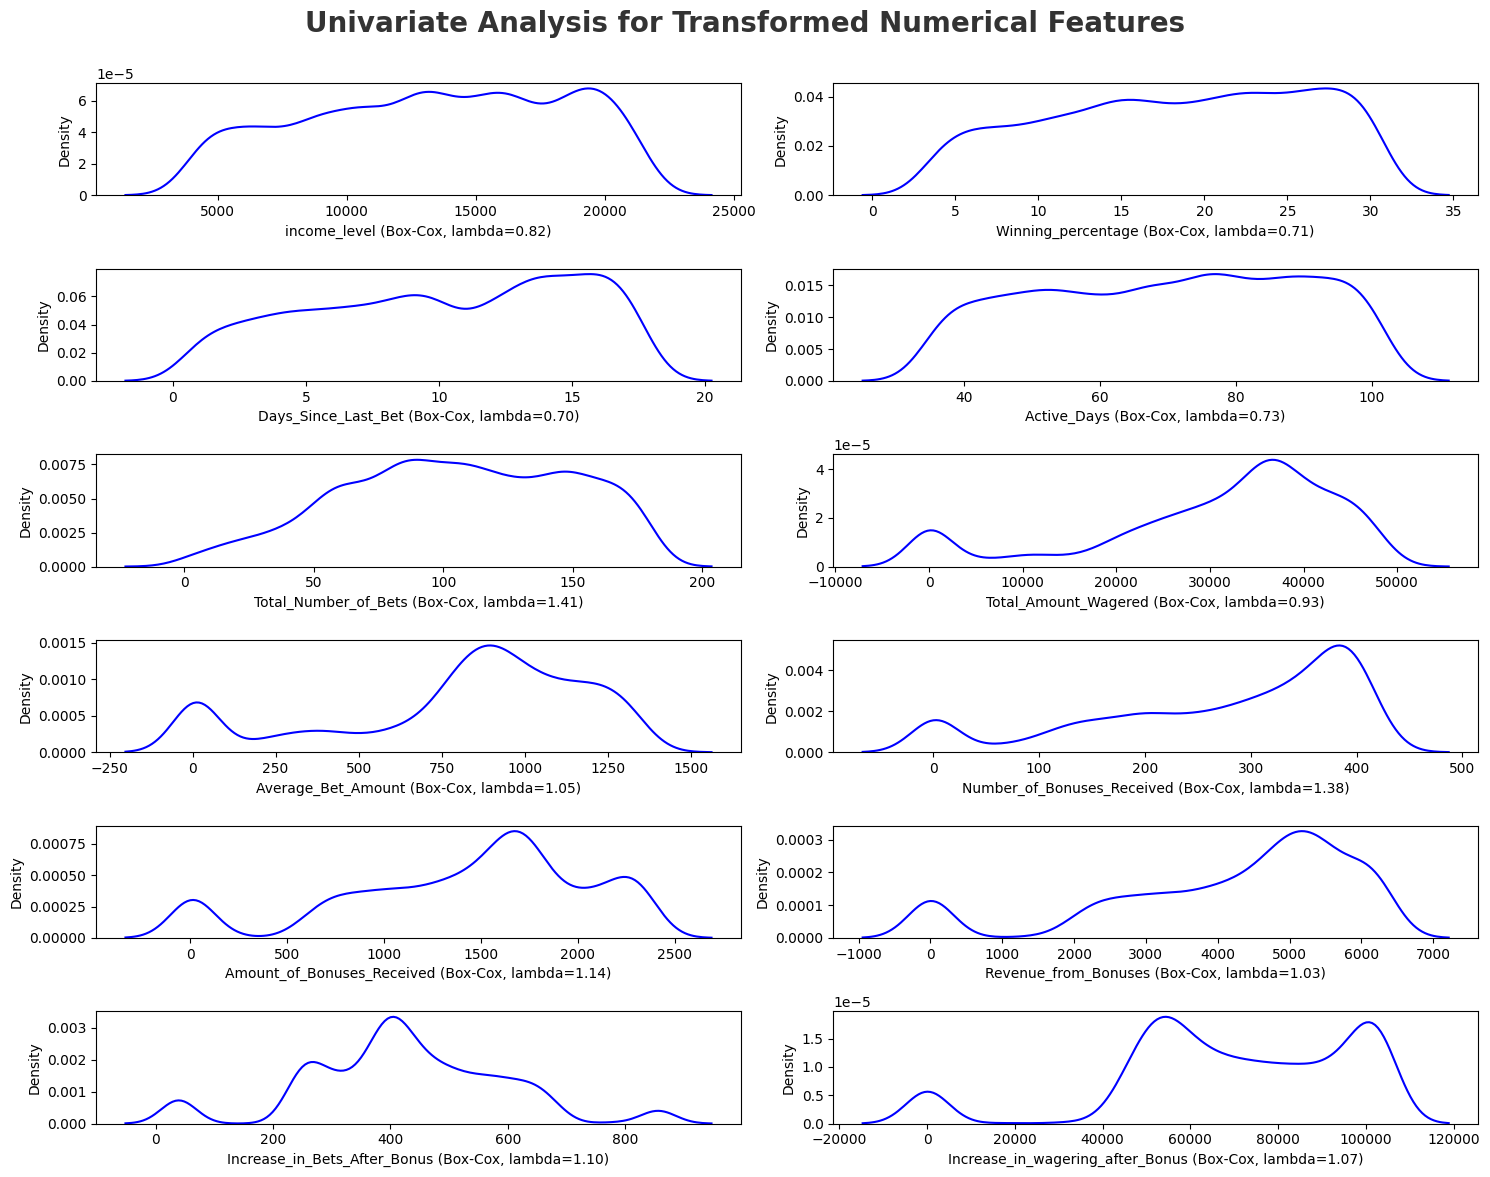

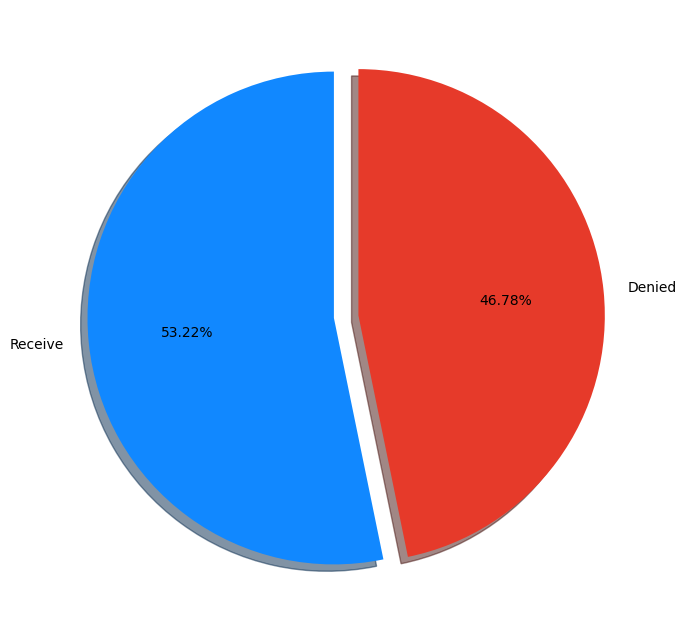

[Splited data into training and test sets]
[Shape of the training data]
[(3750, 6)]
[Shape of the test data]
[(1250, 6)]


In [77]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    data_transformation = DataTransformation(config=data_transformation_config)
    data_transformation.train_test_spliting()
except Exception as e:
    raise e